<a href="https://colab.research.google.com/github/ovad4221/prevention_of_damage_from_accidents/blob/ovad_branch_analys/Analysis_ovad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# основная часть

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/final_accidents_data.xlsx')
df.head(5)

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   coordL                7888 non-null   float64       
 1   coordW                7888 non-null   float64       
 2   place                 7888 non-null   object        
 3   district              7888 non-null   object        
 4   DTPType               7888 non-null   object        
 5   date                  7888 non-null   object        
 6   real_date             7888 non-null   datetime64[ns]
 7   month                 7888 non-null   int64         
 8   season                7888 non-null   object        
 9   NVehicles             7888 non-null   int64         
 10  NPatricipants         7888 non-null   int64         
 11  NInjured              7888 non-null   int64         
 12  NFatal                7888 non-null   int64         
 13  additionalFactor  

## все о РИТА

В России существуют множество статей и гостов по определению материального ущерба от ДТП, например, есть структура EMPY для оценки вреда ТС, в которой содержаться статьи:

  * «О единой методике определения размера расходов на восстановительный ремонт в отношении поврежденного транспортного средства» N 432-П.
  * «О правилах проведения независимой технической экспертизы транспортного средства» N 433-П.
  * Электронная база стоимости запчастей.
Всего в документе 7 глав и 10 приложений-справочников. В главах подробно изложен порядок экспертиз после ДТП, процесс установки характера дефектов, описаны алгоритмы расчетов стоимости ремонта. В справочниках изложены:

1. — требования к проведению фотосъемки;
2. ⬇⬇⬇⬇⬇
3. — перечень типовых повреждений и рекомендации производителей по ремонту кузова (иномарки);
4. — цены на запасные части по регионам. Всего определено 13 зон, в каждой из которых действуют свои цены. Например, запчасти в Санкт-Петербурге и Москве значительно дороже, чем в среднем по России;
5. ⬇⬇⬇⬇⬇
6. — коэффициенты износа, дополнительные сведения;
7. — детали, для которых износ не предусмотрен (показатель износа — 0);
8. — данные по среднегодовому пробегу машины по регионам;
9. — коэффициенты эксплуатации;
10. — коэффициенты механических повреждений.

Или так же есть много других статей по поводу возмещения матереального ущерба, например, "Федеральный закон "Об обязательном страховании гражданской ответственности владельцев транспортных средств", но в нашем датсете данных для полной оценки материального ущерба от аварии нет. 
___
Изначально планировалось составить 2 индекса, индекс оценки материального ущерба, и индекс оценки тяжести аварии, но после попыток их создать оказалось, что такие индексы будут сильно влиять друг на друга и нельзя составить индекс материального ущерба, без учета человеческих потерь и травм. Исходя из этого мы решили объединить индексы в один общий индекс ущерба аварии, который назовем Рассчетный Индекс Тяжести Аварии или РИТА.
___
По поводу оценки человеческих потерь в РИТА-е мы опираемся на ОСАГО. Например, возьмем статью 12 п7. Там сказано 

"Размер страховой выплаты за причинение вреда жизни потерпевшего составляет:
475 тысяч рублей - выгодоприобретателям, указанным в пункте 6 настоящей статьи;
не более 25 тысяч рублей в счет возмещения расходов на погребение - лицам, понесшим такие расходы."
___
Для каждого пункта будем подсчитывать примерную стоимость единицы, если такое возможно.

в РИТА-е учтем столбцы:
  * NVehicles (число автомобилей участников) 100000;
  * NPatricipants (число участников) с малым коэф. из-за моральных компенсаций 500;
  * NInjured (число пострадавших) 15000;
  * NFatal (число погибших) 500000;
  * traffic_regime (изменение режима движения в результате ДТП) ;
  * neispravnosti;
  * privod, как еще однин столбец про сами ТС, скажем, что 4 колеса тормозят лучше 2.


Далее зададим коэффициенты этой регрессии.

Коэффициенты регрессии:
  * NVehicles  --  100;
  * NPatricipants  --  0.5;
  * NInjured  --  15;
  * NFatal  --  500;
  * traffic_regime  --  traffic_regime_index;
  * neispravnosti  --  neispravnosti_index;
  * privod  --  privod_index.

### traffic_regime_index

https://yandex.ru/company/researches/2017/moscow_districts

In [ ]:
reiting_yandex = pd.read_csv('/content/drive/MyDrive/merge_preprocessing_dano/files/raiting_yandex.csv', sep=";")
reiting_yandex.head()

,district,little_infra,comfort_for_life,wery_comfort_for_life,not_happy,colture,happynass,culture-happy,place_in_life_infra,place_in_happy,raiting_of_life,raiting_of_happy
0,Академический,4,31,65,16,2,51,31,7,25,91,76
1,Алексеевский,17,57,26,6,3,54,37,72,16,74,85
2,Алтуфьевский,15,45,40,50,0,50,0,55,66,78,42
3,Арбат,0,0,100,0,0,0,100,1,3,100,100
4,Аэропорт,3,32,65,16,0,49,35,5,23,92,76


отсюда нам нужен только рейтинг жизни в районах, используем его как коэффициент

In [ ]:
life_raiting = dict()
for i in range(len(reiting_yandex)):
  life_raiting[reiting_yandex.loc[i, 'district']] = reiting_yandex.loc[i, 'raiting_of_life']
print(life_raiting)

{'Академический': 91, 'Алексеевский': 74, 'Алтуфьевский': 78, 'Арбат': 100, 'Аэропорт': 92, 'Бабушкинский': 80, 'Басманный': 91, 'Беговой': 85, 'Бескудниковский': 79, 'Бибирево': 84, 'Бирюлёво Восточное': 62, 'Бирюлёво Западное': 72, 'Богородское': 79, 'Братеево': 80, 'Бутырский': 87, 'Вешняки': 75, 'Войковский': 58, 'Восточное Дегунино': 67, 'Восточное Измайлово': 85, 'Выхино-Жулебино': 74, 'Гагаринский': 75, 'Головинский': 59, 'Гольяново': 68, 'Даниловский': 36, 'Дмитровский': 67, 'Донской': 55, 'Дорогомилово': 86, 'Замоскворечье': 87, 'Западное Дегунино': 82, 'Зюзино': 78, 'Зябликово': 81, 'Ивановское': 73, 'Измайлово': 82, 'Капотня': 42, 'Коньково': 88, 'Коптево': 80, 'Косино-Ухтомский': 60, 'Котловка': 87, 'Красносельский': 80, 'Крылатское': 79, 'Кузьминки': 77, 'Кунцево': 76, 'Куркино': 46, 'Левобережный': 54, 'Лефортово': 84, 'Лианозово': 85, 'Ломоносовский': 86, 'Лосиноостровский': 73, 'Люблино': 61, 'Марфино': 56, 'Марьина Роща': 93, 'Марьино': 78, 'Метрогородок': 85, 'Мещанск

In [ ]:
def find_reit(district):
  if district in life_raiting:
    return life_raiting[district] / 10
  else:
    return 1


def replace_traf(string, koef_dist):
  if string == 'Режим движения не изменялся':
    return 0
  elif string == 'Движение частично перекрыто':
    return 25 * koef_dist
  else:
    return 300 * koef_dist

df['traffic_regime_index'] = [replace_traf(df.loc[i, 'traffic_regime'], find_reit(df.loc[i, 'district'])) for i in range(len(df))]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0


### neispravnosti_index

In [ ]:
df.neispravnosti.value_counts()

Технические неисправности отсутствуют    7554
Имеются неисправности                     334
Name: neispravnosti, dtype: int64

In [ ]:
def replace_neis(string):
  if string == 'Технические неисправности отсутствуют':
    return 0
  else:
    return 15

df['neispravnosti_index'] = [replace_neis(i) for i in df['neispravnosti']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0


In [ ]:
df.neispravnosti_index.value_counts()

0     7554
15     334
Name: neispravnosti_index, dtype: int64

### privod_index

In [ ]:
df.privod.value_counts()

передний                             3913
задний,передний                       733
полный,передний                       706
задний                                652
передний,праворукий                   579
полный                                513
праворукий                            302
полный,праворукий                     120
полный,задний                          91
задний,праворукий                      79
полный,задний,передний                 61
Нет информации                         60
полный,передний,праворукий             42
задний,передний,праворукий             29
полный,задний,передний,праворукий       5
полный,задний,праворукий                3
Name: privod, dtype: int64

In [ ]:
def replace_privod(string):
  index = 0
  if 'полный' in string:
    index += -5
  if 'задний' in string:
    index += 5
  if 'передний' in string:
    index += 10
  if 'праворукий' in string:
    index += 15
  return index

df['privod_index'] = [replace_privod(i) for i in df['privod']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10


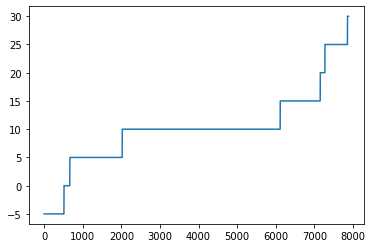

In [ ]:
from copy import deepcopy
df1 = deepcopy(df)
plt.plot(range(7888), df1.sort_values(by='privod_index')['privod_index'].values)
plt.show()

## рассчет РИТА-а

добавить в риту коэффициент инфляции и стоимости по районам

In [ ]:
def for_rita(NVehicles, NPatricipants, NInjured, NFatal, traffic_regime_index, neispravnosti_index, privod_index):
  return NPatricipants * 0.5 + NInjured * 15 + NFatal * 500 + traffic_regime_index + neispravnosti_index + privod_index + NVehicles * 100

In [ ]:
df.loc[6974, 'privod_index']

10

In [ ]:
df['RITA'] = [for_rita(df.loc[i, 'NVehicles'], df.loc[i, 'NPatricipants'], df.loc[i, 'NInjured'], df.loc[i, 'NFatal'], df.loc[i, 'traffic_regime_index'], df.loc[i, 'neispravnosti_index'], df.loc[i, 'privod_index']) for i in range(len(df))]

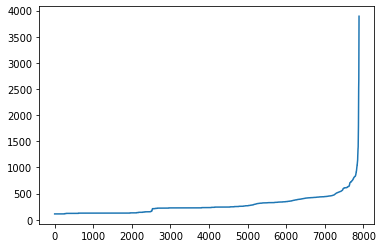

In [ ]:
plt.plot(range(7888), df.sort_values(by='RITA')['RITA'].values)

In [ ]:
df['FAIL'] = [df.loc[i, 'NPatricipants'] +  df.loc[i, 'NInjured'] * 1.5 +  df.loc[i, 'NFatal'] * 500 for i in range(len(df))]

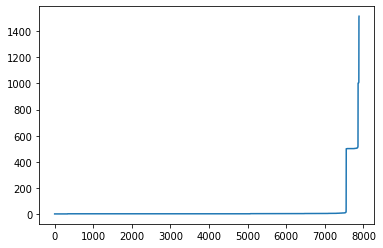

In [ ]:
plt.plot(range(7888), df.sort_values(by='FAIL')['FAIL'].values)

In [ ]:
df.groupby('violations').agg({'RITA':'mean', 'FAIL': 'mean'})

,RITA,FAIL
violations,,
Выезд на полосу встречного движения,419.367424,81.178030
"Выезд на полосу встречного движения в местах, где это запрещено",370.916667,4.916667
"Выезд на полосу встречного движения с разворотом, поворотом налево или объездом препятствия",298.333333,3.722222
Движение во встречном направлении по дороге с односторонним движением,289.750000,3.500000
Другие нарушения ПДД водителем,205.047619,39.142857
Другие нарушения ПДД водителями (не применяется с 12.2020),173.333333,3.166667
Иные нарушения,421.250000,254.000000
Нарушение правил буксировки,332.000000,5.500000
Нарушение правил обгона,388.500000,3.500000


In [ ]:
df.to_excel('accidents_with_RITA.xlsx')

## продолжение 

In [ ]:
df = df.sort_values(by='RITA')
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL
716,37.316040,55.476567,Калужское ш.,Троицк,Наезд на препятствие,29.01.2020,2020-01-29,1,Winter,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),АЗС,Нарушение правил расположения ТС на проезжей ч...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Троицкий Адм. округ,0.0,0,-5,110.5,2.5
1046,37.288510,55.591903,M3,"Филимонковское, Поселение",Наезд на препятствие,11.02.2020,2020-11-02,11,Autumn,1,1,1,0,Сведения отсутствуют,1.0,Снегопад(туман),Перегон (нет объектов на месте ДТП),"Аэропорт, ж/д вокзал (ж/д станция), речной или...",Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Снег и/или лёд,Технические неисправности отсутствуют,Нет,Новомосковский Адм. округ,0.0,0,-5,110.5,2.5
2327,37.585140,55.792759,ул Бутырская,Савеловский,Наезд на препятствие,19.04.2020,2020-04-19,4,Spring,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,"Мост, эстакада, путепровод",АЗС,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северный административный округ,0.0,0,-5,110.5,2.5
6522,37.704724,55.642458,ул Донецкая,Марьино,Наезд на препятствие,05.11.2020,2020-05-11,5,Spring,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Восточный административный округ,0.0,0,-5,110.5,2.5
6889,37.619344,55.804477,12-й пр. Марьиной Рощи,Марьина Роща,Наезд на препятствие,21.11.2020,2020-11-21,11,Autumn,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Внутридворовая территория,Административные здания,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,-5,110.5,2.5


In [ ]:
df['indexes'] = range(7888)
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,indexes
716,37.316040,55.476567,Калужское ш.,Троицк,Наезд на препятствие,29.01.2020,2020-01-29,1,Winter,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),АЗС,Нарушение правил расположения ТС на проезжей ч...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Троицкий Адм. округ,0.0,0,-5,110.5,2.5,0
1046,37.288510,55.591903,M3,"Филимонковское, Поселение",Наезд на препятствие,11.02.2020,2020-11-02,11,Autumn,1,1,1,0,Сведения отсутствуют,1.0,Снегопад(туман),Перегон (нет объектов на месте ДТП),"Аэропорт, ж/д вокзал (ж/д станция), речной или...",Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Снег и/или лёд,Технические неисправности отсутствуют,Нет,Новомосковский Адм. округ,0.0,0,-5,110.5,2.5,1
2327,37.585140,55.792759,ул Бутырская,Савеловский,Наезд на препятствие,19.04.2020,2020-04-19,4,Spring,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,"Мост, эстакада, путепровод",АЗС,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северный административный округ,0.0,0,-5,110.5,2.5,2
6522,37.704724,55.642458,ул Донецкая,Марьино,Наезд на препятствие,05.11.2020,2020-05-11,5,Spring,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Восточный административный округ,0.0,0,-5,110.5,2.5,3
6889,37.619344,55.804477,12-й пр. Марьиной Рощи,Марьина Роща,Наезд на препятствие,21.11.2020,2020-11-21,11,Autumn,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Внутридворовая территория,Административные здания,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,-5,110.5,2.5,4


# доп для анализа

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/violations_brief.xlsx')
df1.head()

,Unnamed: 0,index,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brief
0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


In [ ]:
df1.violations.value_counts()

Неправильный выбор дистанции                                          1137
Нарушение правил проезда пешеходного перехода                          970
Несоблюдение очередности проезда                                       962
Несоответствие скорости конкретным условиям движения                   764
Нарушение правил перестроения                                          405
Несоблюдение условий, разрешающих движение транспорта задним ходом     317
Нарушение требований сигналов светофора                                290
Нарушение правил пользования общественным транспортом                  215
Иные нарушения                                                         213
Выезд на полосу встречного движения                                    132
Нарушение правил расположения ТС на проезжей части                     128
Непредоставление преимущества в движении пешеходу                       87
Несоблюдение бокового интервала                                         84
Name: violations, dtype: 

In [ ]:
# стремление сделать лаконичную запись ошибок
def zamena(string):
  if string == 'Неправильный выбор дистанции':
    return 'Выбор дистанции'
  elif string == 'Нарушение правил проезда пешеходного перехода':
    return 'Пешеходный переход'
  elif string == 'Несоблюдение очередности проезда':
    return 'Очередь проезда'
  elif string == 'Несоответствие скорости конкретным условиям движения':
    return 'Скоростной режим'
  elif string == 'Нарушение правил перестроения':
    return 'Правила перестроения'
  elif string == 'Несоблюдение условий, разрешающих движение транспорта задним ходом':
    return 'Задний ход'
  elif string == 'Нарушение требований сигналов светофора':
    return 'Игнор светофора'
  elif string == 'Нарушение правил пользования общественным транспортом':
    return 'Общ. транспорт'
  elif string == 'Выезд на полосу встречного движения':
    return 'Выезд на встречку'
  elif string == 'Нарушение правил расположения ТС на проезжей части':
    return 'Расположение ТС'
  elif string == 'Непредоставление преимущества в движении пешеходу':
    return 'Игнор пешехода'
  elif string == 'Несоблюдение бокового интервала':
    return 'Боковой интервал'
  else:
    return string

In [ ]:
del df1['violations_brif']

In [ ]:
df1['violations_brief'] = [zamena(i) for i in df1['violations']]
df1.head()

,Unnamed: 0,index,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brief
0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


In [ ]:
df1.to_excel('violations_brief.xlsx', index=False)

# регрессии и CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostRegressor, Pool, cv

In [ ]:
viol = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/violations_brief.xlsx')
viol.head()

,Unnamed: 0,index,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brief
0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


In [ ]:
y = viol.RITA
x = viol[['violations_brief', 'district']]

In [ ]:
y.head(5)

0    125.5
1    391.0
2    131.0
3    421.5
4    126.0
Name: RITA, dtype: float64

In [ ]:
params = {"iterations": 300,
          "depth": 3,
          "loss_function": "RMSE",
          "verbose": False}

In [ ]:
cbr = CatBoostRegressor(random_seed=42)

In [ ]:
x = Pool(x, label=y, cat_features=['violations_brief', 'DTPType', 'district', 'season', 'closeObjects'])

In [ ]:
grid = {'iterations': [200, 600, 1000],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}

cbr.grid_search(grid, X=x, plot=True, verbose=True)

In [ ]:
cbr.feature_importances_

array([17.01071589, 22.99340665, 26.00364404,  3.92848107, 13.37604837,
       16.68770398])

In [ ]:
cbr.feature_names_

['violations_brief', 'DTPType', 'district', 'month', 'season', 'closeObjects']

In [ ]:
features_weights = pd.Series(cbr.feature_importances_, index=cbr.feature_names_, name="reg coef")

In [ ]:
features_weights

violations_brief    17.010716
DTPType             22.993407
district            26.003644
month                3.928481
season              13.376048
closeObjects        16.687704
Name: reg coef, dtype: float64

# Алгоритм выявления рекомендаций

In [90]:
viol = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/violations_brief.xlsx')
viol.head()

,Unnamed: 0,index,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brief
0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


## Динамика

по сезонности (district, season)

In [27]:
def convert(matrix):
  help_dict = {}
  for elem in matrix:
    if elem[0] in help_dict:
      help_dict[elem[0]][0] += elem[1]
      help_dict[elem[0]][1] += 1
    else:
      help_dict[elem[0]] = [elem[1], 1]
  for i in help_dict:
    help_dict[i] = help_dict[i][0] / help_dict[i][1]
  return pd.Series(help_dict)

In [173]:
def count_find(column1, column2, blowki, viol):
  count_ch = len(viol[(viol[f'{column1}']==f'{blowki[0]}') & (viol[f'{column2}']==f'{blowki[1]}')])
  return count_ch 

In [179]:
def locate_blowouts(key, dict_value, blowouts, Q3, razm, column1, column2, viol):
  for i in dict_value:
    if dict_value[i] > Q3 + razm and count_find(column1, column2, i, viol) > 5:
      print(f'Выброс при обстоятельствах {i} - {dict_value[i]}, {count_find(column1, column2, i, viol)}')
      blowouts[key].append((i, dict_value[i], count_find(column1, column2, i, viol)))
  return blowouts

In [175]:
def general_search(column1, column2, viol):
  set_inst = set([(viol.loc[i, column1], viol.loc[i, column2]) for i in range(len(viol))])
  dict_inst = dict()
  for i in set_inst:
    dict_inst[i] = []
  for i in range(len(viol)):
    dict_inst[(viol.loc[i, column1], viol.loc[i, column2])].append([viol.loc[i, 'violations_brief'], viol.loc[i, 'RITA']])
  # преобразование dict_inst
  for key in dict_inst:
    dict_inst[key] = convert(dict_inst[key])
  # задание и заполнение viol_list из dict_inst
  viol_dict = {}
  for key in dict_inst:
    seri = dict_inst[key]
    for violation in seri.index:
      if violation in viol_dict:
        if key in viol_dict[violation]:
          viol_dict[violation][key][0] += seri[violation]
          viol_dict[violation][key][1] += 1
        else:
          viol_dict[violation][key] = [seri[violation], 1]
      else:
        viol_dict[violation] = {key: [seri[violation], 1]}

  for key in viol_dict:
    for key1 in viol_dict[key]:
      viol_dict[key][key1] = viol_dict[key][key1][0] / viol_dict[key][key1][1]
  # словарь выбросов
  blowouts = {i: [] for i in viol_dict}
  # поиск внешних границ данных
  l = []
  for i in viol_dict:
    l.extend(viol_dict[i].values())
  arr = np.array(l)
  len(arr)
  Q1 = np.percentile(arr, 25)
  Q3 = np.percentile(arr, 75)
  razm = (Q3 - Q1) * 3
  # сам поиск выбросов и их вывод на экран
  for key in viol_dict:
    print(f'{key}:')
    blowouts = locate_blowouts(key, viol_dict[key], blowouts, Q3, razm, column1, column2, viol)
    print('\n\n\n') 
  # преобразование словаря
  for i in blowouts:
    blowouts[i] = list(set(blowouts[i]))
  # добавление данных про количество аварий
  # for key in blowouts:
   #  for i in range(len(blowouts[key])):
     #  blowouts[key][i] = (blowouts[key][i][0], blowouts[key][i][1], count_find(column1, column2, blowouts[key][i], viol))

  return blowouts

In [180]:
blowouts_out = general_search('district', 'season', viol)

Общ. транспорт:




Задний ход:
Выброс при обстоятельствах ('Братеево', 'Winter') - 2526.0, 11
Выброс при обстоятельствах ('Чертаново Центральное', 'Winter') - 1401.0, 26
Выброс при обстоятельствах ('Коньково', 'Winter') - 1166.0, 15
Выброс при обстоятельствах ('Пресненский', 'Spring') - 2511.0, 21




Иные нарушения:




Скоростной режим:
Выброс при обстоятельствах ('Северное Тушино', 'Spring') - 3891.5, 8
Выброс при обстоятельствах ('Даниловский', 'Spring') - 928.0, 14
Выброс при обстоятельствах ('Чертаново Северное', 'Winter') - 2436.5, 11
Выброс при обстоятельствах ('Кунцево', 'Autumn') - 1007.0, 16




Выезд на встречку:
Выброс при обстоятельствах ('Савеловский', 'Winter') - 1114.5, 8
Выброс при обстоятельствах ('Мещанский', 'Summer') - 2902.0, 12
Выброс при обстоятельствах ('Ховрино', 'Summer') - 939.5, 13
Выброс при обстоятельствах ('Даниловский', 'Autumn') - 1301.0, 20




Выбор дистанции:
Выброс при обстоятельствах ('Новокосино', 'Winter') - 1539.5, 8




Очередь проезда:






In [122]:
exec("count_ch = len(viol[(viol.district=='Коньково') & (viol.season=='Winter')])")
count_ch

15

In [85]:
blowouts_out = general_search('district', 'lightConditions', viol)

Скоростной режим:
Выброс при обстоятельствах ('Кленовское, Поселение', 0.0) - 1096.0
Выброс при обстоятельствах ('Чертаново Северное', 0.5) - 2436.5
Выброс при обстоятельствах ('Северное Тушино', 0.0) - 3891.5




Игнор светофора:




Выбор дистанции:




Пешеходный переход:
Выброс при обстоятельствах ('Кузьминки', 0.5) - 965.375




Очередь проезда:




Задний ход:
Выброс при обстоятельствах ('Братеево', 1.0) - 2526.0
Выброс при обстоятельствах ('Коньково', 1.0) - 1166.0




Иные нарушения:




Общ. транспорт:




Правила перестроения:
Выброс при обстоятельствах ('Нагорный', 0.5) - 939.5




Расположение ТС:
Выброс при обстоятельствах ('Краснопахорское, Поселение', 0.5) - 952.0




Игнор пешехода:




Боковой интервал:
Выброс при обстоятельствах ('Михайлово-ярцевское, Поселение', 0.0) - 906.0




Выезд на встречку:
Выброс при обстоятельствах ('Ховрино', 1.0) - 939.5
Выброс при обстоятельствах ('Силино', 0.5) - 1242.0
Выброс при обстоятельствах ('Даниловский', 0.5) - 1301.0
Выброс при 

AttributeError: ignored